In [2]:
import pandas as pd
import numpy as np

#Import csv files and putting them in a dictionary
file_names = ["1.4.1", "1.2.3", "1.4.2", "1.3.2", "1.3.1", "1.2.2", "1.2.1", "1.1.1"]
#file_names = ["1.1.1"]
votes = [pd.read_csv(file_name+".csv", index_col=0) for file_name in file_names]
votes_with_nan = [vote.where(vote<2) for vote in votes]
VOTE_DICTIONARY = dict(zip(file_names, votes_with_nan))

#Import Congress data
Congress = pd.read_csv("Congreso.csv", index_col=0)


In [3]:
Congress.loc[Congress["Grupo"] == "Partido Democrático Somos Perú", ["Grupo"]] = "Somos Perú"
Congress.loc[Congress["Grupo"] == "Alianza para el Progreso del Perú", ["Grupo"]] = "Alianza para el Progreso"

Congress.loc[Congress["Bancada"] == "ACCION POPULAR", ["Bancada"]] = "ACCIÓN POPULAR"

In [4]:
Congress["Grupo"].unique()

array(['Alianza para el Progreso', 'Partido Politico Nacional Perú Libre',
       'Fuerza Popular', 'Somos Perú', 'Acción Popular',
       'Avanza País - Partido de Integración Social', 'Podemos Perú',
       'Renovación Popular', 'Juntos por el Perú', 'Partido Morado'],
      dtype=object)

In [5]:
VOTOS = pd.concat(votes_with_nan, axis=1)
VOTOS

,VOTACIÓN DEL PROYECTO 1271,VOTACIÓN DEL NUEVO TEXTO SUSTITUTORIO DE LOS PROYECTOS 327 Y 905,VOTACIÓN DE L A EXONERACIÓN DE SEGUNDA VOTACIÓN DE LOS PROYECTOS 327 Y 905,VOTACIÓN DEL TEXTO SUSTITUTORIO DEL PROYECTO 699,VOTACIÓN DE LA EXONERACIÓN DE SEGUNDA VOTACIÓN DEL PROYECTO 699,VOTACIÓN DEL TEXTO SUSTITUTORIO DE LOS PROYECTOS 668 Y 1073,VOTACIÓN DE LA EXONERACIÓN DE SEGUNDA VOTACIÓN DEL TEXTO SUSTITUTORIO DE LOS PROYECTOS 668 Y 1073,VOTACIÓN DE LA RECONSIDERACIÓN A LA VOTACIÓN DEL TEXTO SUSTITUTORIO DE LOS PROYECTOS 668 Y 1073,VOTACIÓN DE LA CUESTIÓN DE CONFIANZA PLANTEADA POR EL PRESIDENTE DEL CONSEJO DE MINISTROS,LA VOTACIÓN DE LA RECONSIDERACIÓN DE LA VOTACIÓN DEL PROYECTO 1271,VOTACIÓN DE LA ADMISIÓN DE LA MOCIÓN 2064,VOTACIÓN DE LA ADMISIÓN DE LA MOCIÓN 2065,VOTACIÓN DE LA ADMISIÓN DE LA MOCIÓN 206 8,VOTACIÓN DEL PROYECTO 799,VOTACIÓN D E LA EXONERACIÓN DE SEGUNDA VOTACIÓN DEL PROYECTO 799,VOTACIÓN DEL NUEVO TEXTO SUSTITUTORIO DEL PROYECTO 1271,VOTACIÓN DE LA EXONERACIÓN DE SEGUNDA VOTACIÓN DEL NUEVO TEXTO SUSTITUTORIO DEL PROYECTO 1271,VOTACIÓN DE LA RECONSIDERACIÓN DE LA VOTACIÓN DEL PROYECTO 1271,VOTACIÓN DE LA INSISTENCIA EN LA AUTÓGRAFA RECAÍDA EN EL PROYECTO 157,LA VOTACIÓN RECAÍDA EN LA ACLARACIÓN RESPECTO DEL PROYECTO 442,VOTACIÓN DEL NUEVO TEXTO SUSTITUTORIO DEL PROYECTO 738,VOTACIÓN DE LA EXONERACIÓN DE SEGUNDA VOTACIÓN DEL NUEVO TEXTO SUSTITUTORIO DEL PROYECTO 738,VOTACIÓN DEL TEXTO SUSTITUTORIO DEL PROYECTO 483,VOTACIÓN DE LA EXONERACIÓN DE SEGUNDA VOTACIÓN DEL TEXTO SUSTITUTORIO DEL PROYECTO 483,VOTACIÓN DE LA EXONERACIÓN DE SEGUNDA VOTACIÓN DEL TEXTO SUSTITUTORIO DEL PROYECTO 259,VOTACIÓN DEL PROYECTO 609,VOTACIÓN DE LA EXONERACIÓN DE SEGUNDA VOTACIÓN DEL PROYECTO 609,VOTACIÓN DE LA ADMISIÓN DE LA MOCIÓN DE VACANCIA PRESIDENCIAL (MOCIÓN 2148 ),VOTACIÓN DEL LA PROPUESTA DEL,VOTACIÓN D E LA PROPUESTA DE LA PRESIDENCIA PARA QUE EL DEBATE Y LA VOTACIÓN DEL PEDIDO DE VACANCIA SE REALICE EL LUNES 2 8 DE MARZO DE 2022 A LAS 1 5 HORAS,VOTACIÓN DEL PROYECTO DE RESOLUCIÓN LEGISLATIVA 228 (ACTUALIZADO),VOTACIÓN DEL PROYECTO DE RESOLUCIÓN LEGISLATIVA 230 (ACTUALIZADO),VOTACIÓN DEL PROYECTO DE RESOLUCIÓN LEGISLATIVA 23 1 (ACTUALIZADO),VOTACIÓN DEL PROYECTO D E RESOLUCIÓN LEGISLATIVA 244 (ACTUALIZADO),VOTACIÓN DEL PROYECTO DE RESOLUCIÓN LEGISLATIVA 2 34 (ACTUALIZADO),VOTACIÓN DEL PROYECTO DE RESOLUCIÓN LEGISLATIVA 235 (ACTUALIZADO),VOTACIÓN DE LA MOCIÓN 1992,VOTACIÓN DEL PROYECTO 298,VOTACIÓN DE LA EXONERACIÓN DE LA SEGUNDA VOTACIÓN DEL PROYECTO 298,VOTACIÓN DEL TEXTO SUSTITUTORIO DEL PROYECTO 1212,...,"VOTACIÓN DE LA NÓMINA DE LA COMISIÓN ESPECIAL MULTIPARTIDARIA ENFOCAD O EN LA IMPLEMENTACIÓN DE LA INFRAESTRUCTURA TECNOLÓGICA EN LAS ETAPAS DEL SISTEMA EDUCATIVO DE ACUERDO CON LA LEY GENERAL DE EDUCACIÓN, LEY 28044 (MOCIÓN 13129)",VOTACIÓN DE LA ADMISIÓN DE LA MOCIÓN DE ORDEN DEL DÍA 14611,VOTACIÓN DE LA MOCIÓN DE ORDEN DEL DÍA 14611,VOTACIÓN DEL TEXTO SUSTITUTORIO DE LOS PROYECTOS 2648 Y 4255,VOTACIÓN DE LA RATIFICACIÓN DEL ACUERDO DE LA JUNTA DE PORTAVOCES RESPECTO DEL PROYECTO 8115 Y OTROS,VOTACIÓN DEL TEXTO SUSTITUTORIO DEL PROYECTO 8115 Y OTROS,VOTACIÓN DEL TEXTO SUSTITUTORIO DEL PROYECTO 6445 Y OTROS,VOTACIÓN DE LA MOCIÓN DE CENSURA AL MINISTRO DE INCLUSIÓN SOCIAL Y DESARROLLO (MOCIÓN 14608),VOTACIÓN DE LA ADMISIÓN DE LA MOCIÓN 14612 ( MOCIÓN DE INTERPELACIÓN AL MINISTRO DE DESARROLLO E INCLUSIÓN SOCIAL ),"VOTACIÓN DE LA CONCURRENCIA DEL MINISTRO DE DESARROLLO E INCLUSIÓN SOCIAL , JULIO JAVIER DEMARTINI MONTES, EL DÍA 4 DE DICIEMBRE DE 2024 A LAS 18 HORAS","VOTACIÓN DE LA RECONSIDERACIÓN A LA VOTACIÓN DE LA MOCIÓN 14608, LA CUAL PROPONE QUE EL",VOTACIÓN DEL TEXTO SUSTITUTORIO DE LAS MOCIONES 14628 y 14629 (CENSURA AL MINISTRO DE ENERGÍA Y MINAS),LA SEGUNDA VOTACIÓN DEL PROYECTO 1320 Y OTROS,"VOTACIÓN DE LA INSISTENCIA EN LA AUTÓGRAFA OBSERVADA POR LA SEÑORA PRESIDENTA DE LA REPÚBLICA , RECAÍDA EN EL PROYECTO 6453",VOTACIÓN DE LA RECONSIDERACIÓN A LA VOTACIÓN DEL DICTAMEN DE INSISTENCIA RESPECTO DEL PROYECTO 3254,

In [6]:
def add_summary_row_single(df):
    # Compute the sum of votes for each column
    column_sums = df.sum(axis=0)
    
    # Determine if the bill passed (+1) or didn't (-1)
    passed_or_not = [1 if x > 0 else -1 for x in column_sums]
    
    # Add the summary row to the DataFrame
    df_with_summary = pd.concat(
        [df, pd.DataFrame([passed_or_not], columns=df.columns, index=["Summary"])],
        axis=0
    )
    return df_with_summary
VOTOS = add_summary_row_single(VOTOS)

In [7]:
def calculate_alignment(df):
    # Extract the summary row (outcomes)
    outcomes = df.loc["Summary"]
    
    # Drop the summary row from the DataFrame to analyze representatives
    representatives = df.drop("Summary")
    
    # Calculate alignment for each representative
    alignment_count = (representatives == outcomes).sum(axis=1)
    
    # Create a DataFrame to store results
    alignment_df = pd.DataFrame({
        "Representative": representatives.index,
        "Aligned": alignment_count
    })
    
    # Sort by number of correct guesses in descending order
    alignment_df = alignment_df.sort_values(by="Aligned", ascending=False).reset_index(drop=True)
    
    return alignment_df


In [8]:
pd.concat([calculate_alignment(VOTOS), Congress["Grupo"]], axis=1).groupby("Grupo").median().sort_values("Aligned")

,Representative,Aligned
Grupo,,
Partido Morado,63.0,1677.0
Partido Politico Nacional Perú Libre,64.0,1752.0
Renovación Popular,80.0,1760.0
Acción Popular,84.0,1790.5
Juntos por el Perú,70.0,1792.0
Fuerza Popular,80.0,1878.0
Somos Perú,66.0,1892.0
Podemos Perú,38.5,1893.0
Alianza para el Progreso,42.5,1900.5


In [9]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
VOTOS_REDUCED = pca.fit_transform(VOTOS.fillna(0))
print(pca.explained_variance_ratio_)
print(pca.singular_values_)


[0.22632498 0.07291563 0.04005594]
[177.93698656 100.99742418  74.85718   ]


In [10]:
VOTOS_REDUCED_DF = pd.concat([pd.DataFrame(VOTOS_REDUCED), Congress], axis=1)
VOTOS_REDUCED_DF

,0,1,2,Congresista,Región,Bancada,Grupo,Votacion
0,13.364469,5.315842,4.737968,Acuña Peralta María Grimaneza,Lambayeque,ALIANZA PARA EL PROGRESO,Alianza para el Progreso,"11,384"
1,-0.666018,-4.879556,8.742510,Acuña Peralta Segundo Héctor,La libertad,HONOR Y DEMOCRACIA,Alianza para el Progreso,"19,729"
2,-22.754921,7.750823,-9.788503,Agüero Gutiérrez María Antonieta,Arequipa,PERÚ LIBRE,Partido Politico Nacional Perú Libre,"29,293"
3,17.858360,-0.218750,-2.116288,Aguinaga Recuenco Alejandro Aurelio,Lambayeque,FUERZA POPULAR,Fuerza Popular,"10,715"
4,0.355258,4.158806,4.323920,Alcarraz Aguero Yorel Kira,LIMA,PODEMOS PERÚ,Somos Perú,"28,404"
...,...,...,...,...,...,...,...,...
134,13.836946,2.104672,1.872653,Zeballos Aponte Jorge Arturo,Peruanos Residentes en el Extranjero,RENOVACIÓN POPULAR,Renovación Popular,"4,691"
135,-9.962824,6.930686,4.441853,Zeballos Madariaga Carlos Javier,Puno,NO AGRUPADO,Acción Popular,"23,883"
136,-5.987738,-27.033279,-7.633402,Zegarra Saboya Ana Zadith,Loreto,SOMOS PERÚ,Somos Perú,"4,917"
137,16.904887,1.901780,-2.862568,Zeta Chunga Cruz María,Piura,FUERZA POPULAR,Fuerza Popular,"10,079"


In [11]:
VOTOS_REDUCED_DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139 entries, 0 to 138
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   0            139 non-null    float64
 1   1            139 non-null    float64
 2   2            139 non-null    float64
 3   Congresista  138 non-null    object 
 4   Región       138 non-null    object 
 5   Bancada      138 non-null    object 
 6   Grupo        138 non-null    object 
 7   Votacion     138 non-null    object 
dtypes: float64(3), object(5)
memory usage: 8.8+ KB


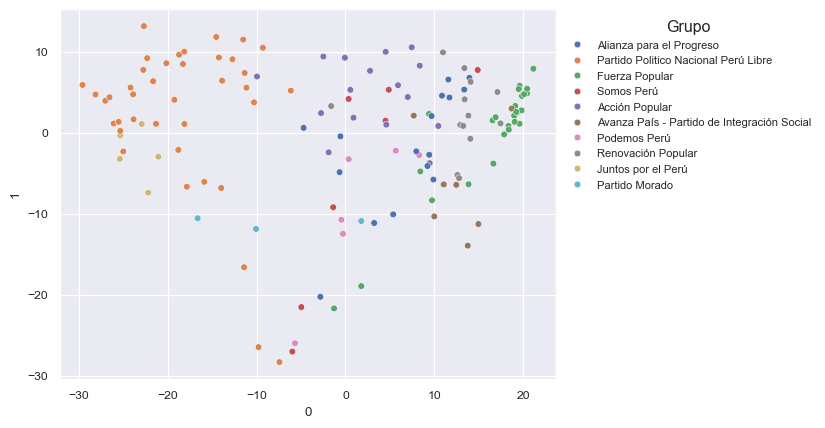

In [12]:
import seaborn as sns
from matplotlib import pyplot as plt

import seaborn as sns
from matplotlib import pyplot as plt
sns.set_theme("paper")

# Create scatterplot
sns.scatterplot(data = VOTOS_REDUCED_DF, x = 0, y = 1, hue = "Grupo")

# Adjust the legend
plt.legend(title='Grupo', bbox_to_anchor=(1, 1), loc='best', frameon=False, title_fontsize='large', fontsize='small', ncol=1)

# Display the plot
#plt.tight_layout()
plt.show()


In [13]:
import plotly.express as px

# Create scatterplot using Plotly
fig = px.scatter_3d(VOTOS_REDUCED_DF, x=0, y=1,z=2, color="Bancada",  hover_data={"Congresista": True})

# Adjust the legend to make it wider
fig.update_layout(
    legend_title="Bancada",
    legend=dict(
        title_font_size=15,
        font_size=10,
        itemsizing='constant',  # Ensure the legend items are sized uniformly
        orientation='v',  # Set legend to horizontal
        x=1.05,  # Move the legend outside of the plot
        y=1,     # Align it with the top of the plot
        xanchor='left',  # Anchor legend to the left of the plot area
    )
)

# Show the plot
fig.show()

In [14]:
#Los congresistas que más se han abstenido.
def add_summary_row_single(df):
    # Compute the sum of votes for each column
    column_sums = df.sum(axis=0)
    
    # Determine if the bill passed (+1) or didn't (-1)
    passed_or_not = [1 if x > 0 else -1 for x in column_sums]
    
    # Add the summary row to the DataFrame
    df_with_summary = pd.concat(
        [df, pd.DataFrame([passed_or_not], columns=df.columns, index=["Summary"])],
        axis=0
    )
    

Text(0.5, 1.0, 'Promedio de abstenciones por bancada en la primera legislatura del periodo anual 2024-2025')

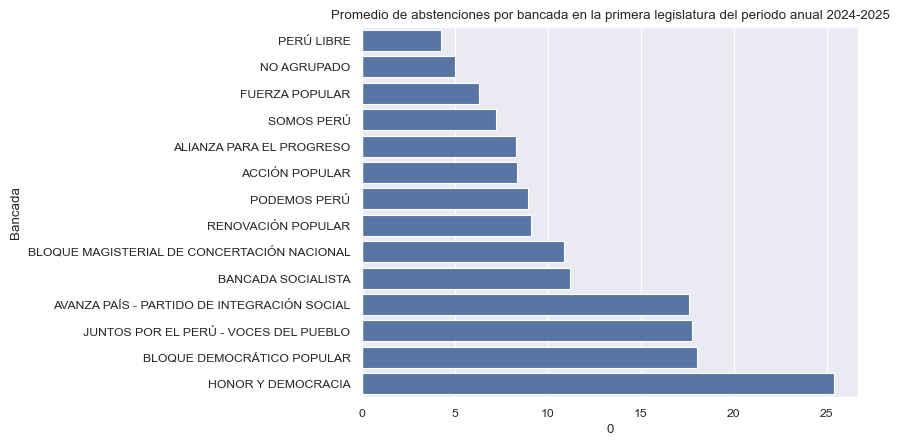

In [15]:
#Bancadas que más se abstuvieron en el periodo Agosto - Noviembre del 2024
sns.barplot(pd.concat([(VOTE_DICTIONARY["1.1.1"]==0).sum(axis=1).sort_values(ascending=False), Congress], axis=1).groupby("Bancada")[0].mean().sort_values(),
            orient="h")
plt.title("Promedio de abstenciones por bancada en la primera legislatura del periodo anual 2024-2025")

Text(0.5, 1.0, 'Mediana de abstenciones por bancada en la primera legislatura del periodo anual 2024-2025')

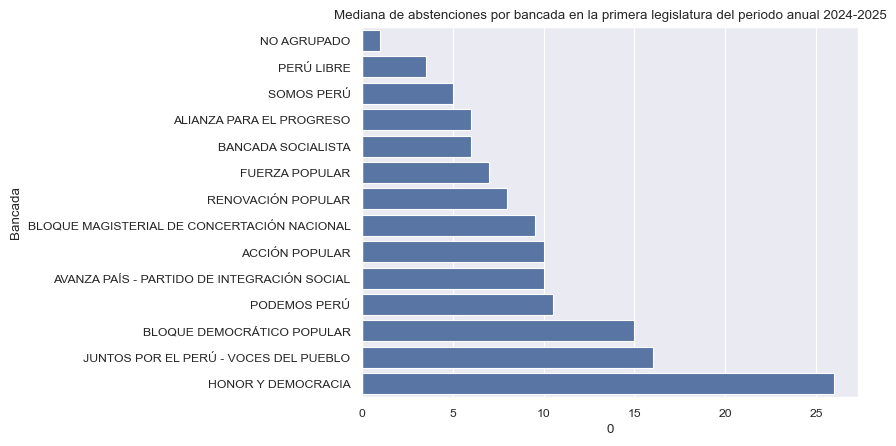

In [16]:
#Bancadas que más se abstuvieron en el periodo Agosto - Noviembre del 2024
sns.barplot(pd.concat([(VOTE_DICTIONARY["1.1.1"]==0).sum(axis=1).sort_values(ascending=False), Congress], axis=1).groupby("Bancada")[0].median().sort_values(),
            orient="h")
plt.title("Mediana de abstenciones por bancada en la primera legislatura del periodo anual 2024-2025")

,0,Congresista
73,57,Málaga Trillo George Edward
42,36,Echaíz de Núñez Izaga Gladys Margot
96,35,Pariona Sinche Alfredo
31,33,Coayla Juárez Jorge Samuel
43,31,Echeverría Rodríguez Hamlet
38,29,Cutipa Ccama Víctor Raúl
72,26,Luque Ibarra Ruth
1,26,Acuña Peralta Segundo Héctor
37,26,Cueto Aservi José Ernesto
35,24,Cortez Aguirre Isabel


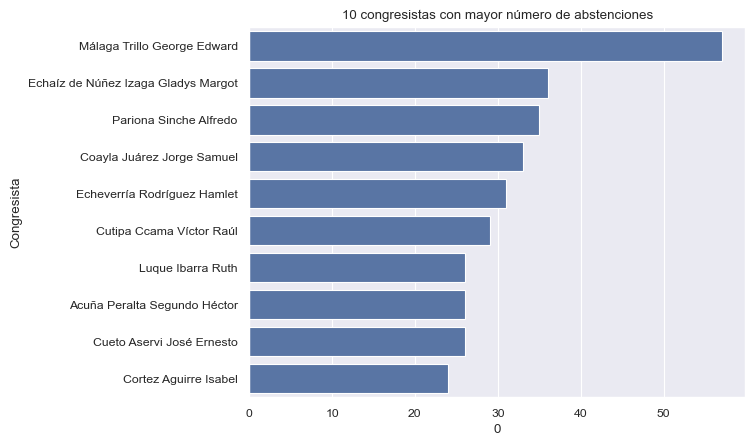

In [17]:
#10 congresistas con mayor número de abstenciones
sns.barplot(data = pd.concat([(VOTE_DICTIONARY["1.1.1"]==0).sum(axis=1).sort_values(ascending=False), Congress], axis=1)[[0, "Congresista"]].sort_values(by=0, ascending=False).head(10),
            x=0,
            y="Congresista", orient="h")
plt.title("10 congresistas con mayor número de abstenciones")
pd.concat([(VOTE_DICTIONARY["1.1.1"]==0).sum(axis=1).sort_values(ascending=False), Congress], axis=1)[[0, "Congresista"]].sort_values(by=0, ascending=False).head(10)

In [84]:
by="Bancada"
pd.concat([VOTE_DICTIONARY["1.1.1"].fillna(0), Congress[by]], axis=1).sort_values(by)[by].unique()

array(['ACCIÓN POPULAR', 'ALIANZA PARA EL PROGRESO',
       'AVANZA PAÍS - PARTIDO DE INTEGRACIÓN SOCIAL',
       'BANCADA SOCIALISTA', 'BLOQUE DEMOCRÁTICO POPULAR',
       'BLOQUE MAGISTERIAL DE CONCERTACIÓN NACIONAL', 'FUERZA POPULAR',
       'HONOR Y DEMOCRACIA', 'JUNTOS POR EL PERÚ - VOCES DEL PUEBLO',
       'NO AGRUPADO', 'PERÚ LIBRE', 'PODEMOS PERÚ', 'RENOVACIÓN POPULAR',
       'SOMOS PERÚ'], dtype=object)

[Text(0, 0, 'ACCIÓN POPULAR'),
 Text(0, 9, 'ALIANZA PARA EL PROGRESO'),
 Text(0, 23, 'AVANZA PAÍS - PARTIDO DE INTEGRACIÓN SOCIAL'),
 Text(0, 30, 'BANCADA SOCIALISTA'),
 Text(0, 35, 'BLOQUE DEMOCRÁTICO POPULAR'),
 Text(0, 40, 'BLOQUE MAGISTERIAL DE CONCERTACIÓN NACIONAL'),
 Text(0, 48, 'FUERZA POPULAR'),
 Text(0, 70, 'HONOR Y DEMOCRACIA'),
 Text(0, 75, 'JUNTOS POR EL PERÚ - VOCES DEL PUEBLO'),
 Text(0, 83, 'NO AGRUPADO'),
 Text(0, 92, 'PERÚ LIBRE'),
 Text(0, 104, 'PODEMOS PERÚ'),
 Text(0, 118, 'RENOVACIÓN POPULAR'),
 Text(0, 129, 'SOMOS PERÚ')]

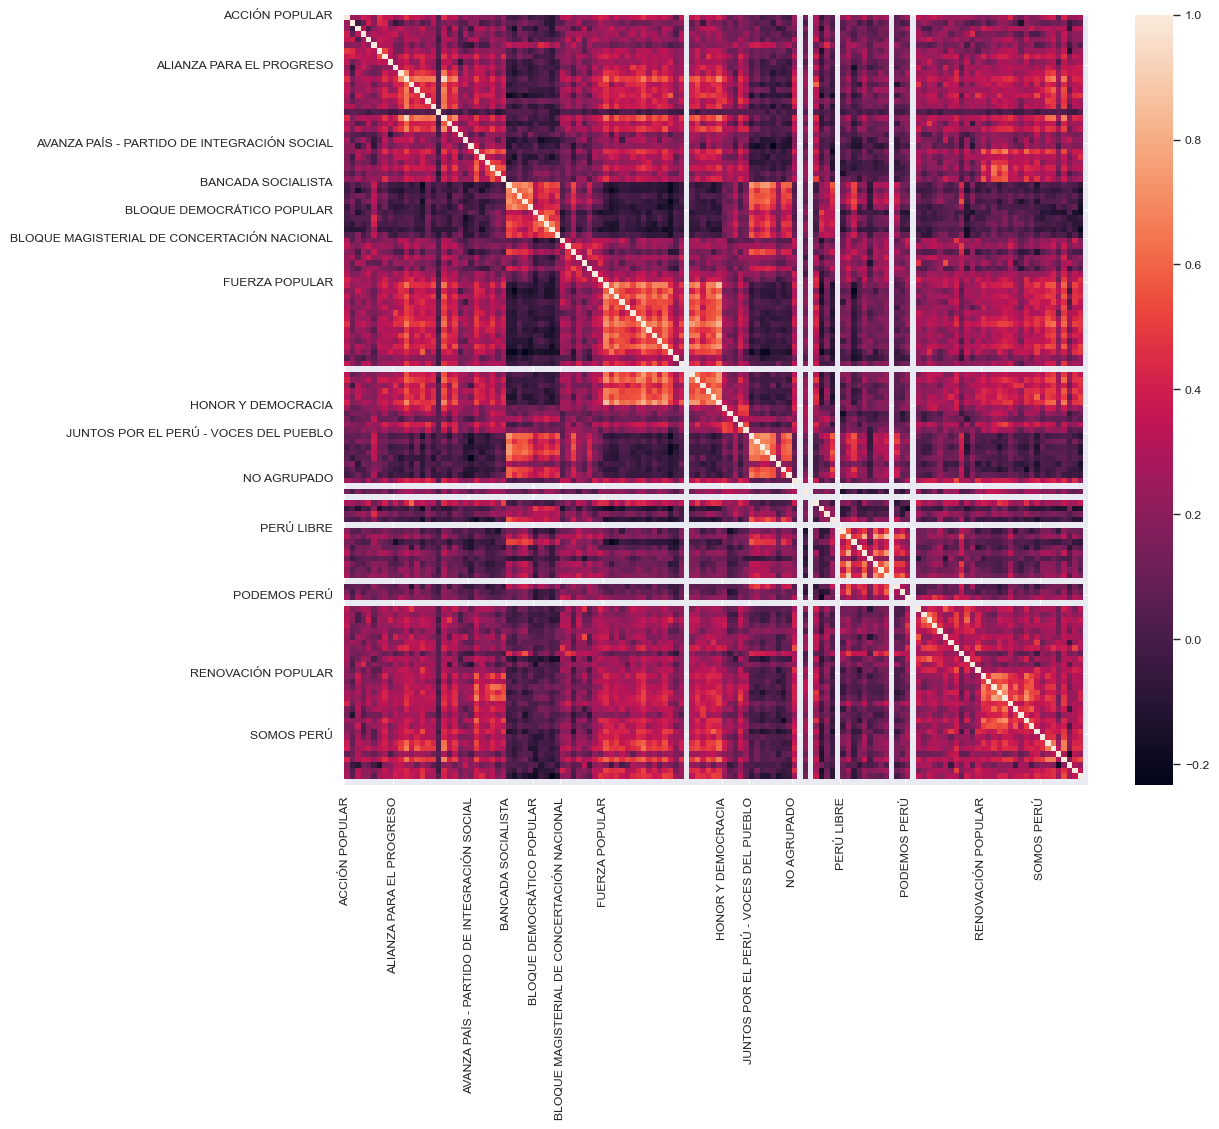

In [86]:
plt.figure(figsize=(12, 10))  # Set figure size (width, height)
by="Bancada"

g = sns.heatmap(pd.concat([VOTE_DICTIONARY["1.1.1"].fillna(0), Congress[by]], axis=1).sort_values(by).drop(by, axis=1).transpose().corr())
asdflk = [0, 9, 23, 30, 35, 40, 48, 70, 75, 83, 92, 104, 118, 129]
asdflk2 = [10, 45, 24, 103, 95, 76, 84, 90, 38, 75, 99, 120, 134, 125]

g.set_xticks(asdflk)
g.set_xticklabels(pd.concat([VOTE_DICTIONARY["1.1.1"].fillna(0), Congress[by]], axis=1).sort_values(by)[by].unique())
g.set_yticks(asdflk)
g.set_yticklabels(pd.concat([VOTE_DICTIONARY["1.1.1"].fillna(0), Congress[by]], axis=1).sort_values(by)[by].unique())


In [19]:
pd.concat([VOTOS.fillna(0), Congress["Bancada"]], axis=1).sort_values("Bancada").groupby("Bancada").count()

,VOTACIÓN DEL PROYECTO 1271,VOTACIÓN DEL NUEVO TEXTO SUSTITUTORIO DE LOS PROYECTOS 327 Y 905,VOTACIÓN DE L A EXONERACIÓN DE SEGUNDA VOTACIÓN DE LOS PROYECTOS 327 Y 905,VOTACIÓN DEL TEXTO SUSTITUTORIO DEL PROYECTO 699,VOTACIÓN DE LA EXONERACIÓN DE SEGUNDA VOTACIÓN DEL PROYECTO 699,VOTACIÓN DEL TEXTO SUSTITUTORIO DE LOS PROYECTOS 668 Y 1073,VOTACIÓN DE LA EXONERACIÓN DE SEGUNDA VOTACIÓN DEL TEXTO SUSTITUTORIO DE LOS PROYECTOS 668 Y 1073,VOTACIÓN DE LA RECONSIDERACIÓN A LA VOTACIÓN DEL TEXTO SUSTITUTORIO DE LOS PROYECTOS 668 Y 1073,VOTACIÓN DE LA CUESTIÓN DE CONFIANZA PLANTEADA POR EL PRESIDENTE DEL CONSEJO DE MINISTROS,LA VOTACIÓN DE LA RECONSIDERACIÓN DE LA VOTACIÓN DEL PROYECTO 1271,VOTACIÓN DE LA ADMISIÓN DE LA MOCIÓN 2064,VOTACIÓN DE LA ADMISIÓN DE LA MOCIÓN 2065,VOTACIÓN DE LA ADMISIÓN DE LA MOCIÓN 206 8,VOTACIÓN DEL PROYECTO 799,VOTACIÓN D E LA EXONERACIÓN DE SEGUNDA VOTACIÓN DEL PROYECTO 799,VOTACIÓN DEL NUEVO TEXTO SUSTITUTORIO DEL PROYECTO 1271,VOTACIÓN DE LA EXONERACIÓN DE SEGUNDA VOTACIÓN DEL NUEVO TEXTO SUSTITUTORIO DEL PROYECTO 1271,VOTACIÓN DE LA RECONSIDERACIÓN DE LA VOTACIÓN DEL PROYECTO 1271,VOTACIÓN DE LA INSISTENCIA EN LA AUTÓGRAFA RECAÍDA EN EL PROYECTO 157,LA VOTACIÓN RECAÍDA EN LA ACLARACIÓN RESPECTO DEL PROYECTO 442,VOTACIÓN DEL NUEVO TEXTO SUSTITUTORIO DEL PROYECTO 738,VOTACIÓN DE LA EXONERACIÓN DE SEGUNDA VOTACIÓN DEL NUEVO TEXTO SUSTITUTORIO DEL PROYECTO 738,VOTACIÓN DEL TEXTO SUSTITUTORIO DEL PROYECTO 483,VOTACIÓN DE LA EXONERACIÓN DE SEGUNDA VOTACIÓN DEL TEXTO SUSTITUTORIO DEL PROYECTO 483,VOTACIÓN DE LA EXONERACIÓN DE SEGUNDA VOTACIÓN DEL TEXTO SUSTITUTORIO DEL PROYECTO 259,VOTACIÓN DEL PROYECTO 609,VOTACIÓN DE LA EXONERACIÓN DE SEGUNDA VOTACIÓN DEL PROYECTO 609,VOTACIÓN DE LA ADMISIÓN DE LA MOCIÓN DE VACANCIA PRESIDENCIAL (MOCIÓN 2148 ),VOTACIÓN DEL LA PROPUESTA DEL,VOTACIÓN D E LA PROPUESTA DE LA PRESIDENCIA PARA QUE EL DEBATE Y LA VOTACIÓN DEL PEDIDO DE VACANCIA SE REALICE EL LUNES 2 8 DE MARZO DE 2022 A LAS 1 5 HORAS,VOTACIÓN DEL PROYECTO DE RESOLUCIÓN LEGISLATIVA 228 (ACTUALIZADO),VOTACIÓN DEL PROYECTO DE RESOLUCIÓN LEGISLATIVA 230 (ACTUALIZADO),VOTACIÓN DEL PROYECTO DE RESOLUCIÓN LEGISLATIVA 23 1 (ACTUALIZADO),VOTACIÓN DEL PROYECTO D E RESOLUCIÓN LEGISLATIVA 244 (ACTUALIZADO),VOTACIÓN DEL PROYECTO DE RESOLUCIÓN LEGISLATIVA 2 34 (ACTUALIZADO),VOTACIÓN DEL PROYECTO DE RESOLUCIÓN LEGISLATIVA 235 (ACTUALIZADO),VOTACIÓN DE LA MOCIÓN 1992,VOTACIÓN DEL PROYECTO 298,VOTACIÓN DE LA EXONERACIÓN DE LA SEGUNDA VOTACIÓN DEL PROYECTO 298,VOTACIÓN DEL TEXTO SUSTITUTORIO DEL PROYECTO 1212,...,"VOTACIÓN DE LA NÓMINA DE LA COMISIÓN ESPECIAL MULTIPARTIDARIA ENFOCAD O EN LA IMPLEMENTACIÓN DE LA INFRAESTRUCTURA TECNOLÓGICA EN LAS ETAPAS DEL SISTEMA EDUCATIVO DE ACUERDO CON LA LEY GENERAL DE EDUCACIÓN, LEY 28044 (MOCIÓN 13129)",VOTACIÓN DE LA ADMISIÓN DE LA MOCIÓN DE ORDEN DEL DÍA 14611,VOTACIÓN DE LA MOCIÓN DE ORDEN DEL DÍA 14611,VOTACIÓN DEL TEXTO SUSTITUTORIO DE LOS PROYECTOS 2648 Y 4255,VOTACIÓN DE LA RATIFICACIÓN DEL ACUERDO DE LA JUNTA DE PORTAVOCES RESPECTO DEL PROYECTO 8115 Y OTROS,VOTACIÓN DEL TEXTO SUSTITUTORIO DEL PROYECTO 8115 Y OTROS,VOTACIÓN DEL TEXTO SUSTITUTORIO DEL PROYECTO 6445 Y OTROS,VOTACIÓN DE LA MOCIÓN DE CENSURA AL MINISTRO DE INCLUSIÓN SOCIAL Y DESARROLLO (MOCIÓN 14608),VOTACIÓN DE LA ADMISIÓN DE LA MOCIÓN 14612 ( MOCIÓN DE INTERPELACIÓN AL MINISTRO DE DESARROLLO E INCLUSIÓN SOCIAL ),"VOTACIÓN DE LA CONCURRENCIA DEL MINISTRO DE DESARROLLO E INCLUSIÓN SOCIAL , JULIO JAVIER DEMARTINI MONTES, EL DÍA 4 DE DICIEMBRE DE 2024 A LAS 18 HORAS","VOTACIÓN DE LA RECONSIDERACIÓN A LA VOTACIÓN DE LA MOCIÓN 14608, LA CUAL PROPONE QUE EL",VOTACIÓN DEL TEXTO SUSTITUTORIO DE LAS MOCIONES 14628 y 14629 (CENSURA AL MINISTRO DE ENERGÍA Y MINAS),LA SEGUNDA VOTACIÓN DEL PROYECTO 1320 Y OTROS,"VOTACIÓN DE LA INSISTENCIA EN LA AUTÓGRAFA OBSERVADA POR LA SEÑORA PRESIDENTA DE LA REPÚBLICA , RECAÍDA EN EL PROYECTO 6453",VOTACIÓN DE LA RECONSIDERACIÓN A LA VOTACIÓN DEL DICTAMEN DE INSISTENCIA RESPECTO DEL PROYECTO 3254,

In [57]:
#apply kmeans
from sklearn.cluster import KMeans
kmeans_total = KMeans(n_clusters=3, random_state=0).fit(VOTOS.drop("Summary", axis=0).fillna(0))
kmeans_1_1_1 = KMeans(n_clusters=3, random_state=0).fit(VOTE_DICTIONARY["1.1.1"].fillna(0))
Congress["Grupo_KMeans"] = kmeans_1_1_1.labels_
Congress.loc[Congress["Grupo_KMeans"] == 2].sort_values("Bancada")

,Congresista,Región,Bancada,Grupo,Votacion,Grupo_KMeans
100,Portero López Hilda Marleny,Lambayeque,ACCIÓN POPULAR,Acción Popular,"8,568",2
129,Vergara Mendoza Elvis Hernán,Ucayali,ACCIÓN POPULAR,Acción Popular,"4,486",2
22,Camones Soriano Lady Mercedes,Ancash,ALIANZA PARA EL PROGRESO,Alianza para el Progreso,"6,203",2
113,Salhuana Cavides Eduardo,Madre de dios,ALIANZA PARA EL PROGRESO,Alianza para el Progreso,"3,013",2
96,Pariona Sinche Alfredo,Huancavelica,BANCADA SOCIALISTA,Partido Politico Nacional Perú Libre,"9,849",2
103,Quito Sarmiento Bernardo Jaime,Arequipa,BANCADA SOCIALISTA,Partido Politico Nacional Perú Libre,"41,430",2
48,Flores Ramírez Alex Randu,Ayacucho,BANCADA SOCIALISTA,Partido Politico Nacional Perú Libre,"21,993",2
39,Dávila Atanacio Pasión Neomias,Pasco,BANCADA SOCIALISTA,Partido Politico Nacional Perú Libre,"3,915",2
109,Robles Araujo Silvana Emperatriz,Junin,BANCADA SOCIALISTA,Partido Politico Nacional Perú Libre,"11,893",2
16,Bazán Narro Sigrid Tesoro,LIMA,BLOQUE DEMOCRÁTICO POPULAR,Juntos por el Perú,"44,359",2
